In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.datasets as datasets 
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np 

from datetime import datetime

device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [ ]:

"""# TODO - 1: DATASET"""

import torchvision.transforms as transforms

transforms = transforms.Compose([transforms.Resize((32,32)),
                                 transforms.ToTensor()])


train_dataset = datasets.MNIST(root='./data',
                                      train=True,
                                      download = True,
                                      transform = transforms)

valid_dataset = datasets.MNIST(root='./data',
                                      train=False,
                                      transform=transforms)


In [ ]:

"""## Convert Dataset to Dataloader"""
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

Text(0.5, 0.98, 'MNIST Dataset')

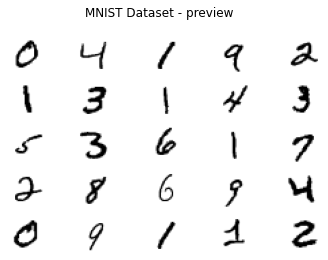

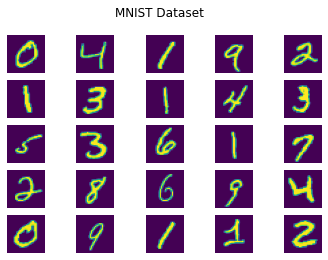

In [ ]:

"""# TODO - 2: Plot the Dataset"""

ROW_IMG = 5
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG*N_ROWS + 1):
  plt.subplot(N_ROWS,ROW_IMG, index)
  plt.axis('off')
  plt.imshow(train_dataset.data[index], cmap='gray_r')
fig.suptitle('MNIST Dataset - preview');

fig = plt.figure()
for index in range(1, ROW_IMG*N_ROWS + 1):
  plt.subplot(N_ROWS, ROW_IMG, index)
  plt.axis('off')
  plt.imshow(train_dataset.data[index])
fig.suptitle('MNIST Dataset')

In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms as tf


class CustomData(Dataset):
  def __init__(self, digit_data):
    self.data = digit_data.data
    self.label = digit_data.train_labels
    size = digit_data.train_labels.size()
    self.random_number = torch.randint(0, 10, size)
    self.random_label = self.label + self.random_number
    self.transform_image = tf.Compose([tf.Resize((32,32)),
                                 tf.ToTensor()])

  def __getitem__(self, index):
    r0 = self.data[index]
    r1 = self.random_number[index]
    r2 = self.label[index]
    r3 = self.random_label[index] 
    image, random_number, label, sum_label = r0, r1, r2, r3
    #image = self.transform_image(image)
    #return (label, sum_label), (image, random_number)
    image = image.reshape(1, 28, 28)
    image = image/255.
    
    


    return torch.tensor([label, sum_label]), image, torch.tensor(random_number)

  def __len__(self):
    return len(self.data)

In [ ]:
custom_dataset = CustomData(train_dataset)
custom_dataset

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [ ]:
a,b,c = next((iter(custom_dataset)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
b.shape

torch.Size([1, 28, 28])

In [ ]:
b.dtype

torch.float32

In [ ]:
plt.imshow(b[0])

In [ ]:

"""## Convert Dataset to Dataloader"""
BATCH_SIZE = 32

import torchvision.transforms as transforms



custom_train_loader = DataLoader(custom_dataset, batch_size=BATCH_SIZE, shuffle=True)


custom_valid_loader = DataLoader(custom_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:

def get_accuracy(model, data_loader, device):
    ''' 
    Function for computing the accuracy of the predictions over the entire dataloader
    '''
    correct_preds = 0
    total_num = 0

    with torch.no_grad():
      model.eval()

      for X,y_true in data_loader:

        X = X.to(device)
        y_true = y_true.to(device)

        _, y_prob = model(X) # model(x) returns a tensor of size (BATCH_SIZE, NUM_CLASSES) - tensor([32,10])
        _, predicted_labels = torch.max(y_prob, dim=1)

        total_num += y_true.size(0)
        correct_preds += (predicted_labels == y_true).sum()
      
      return correct_preds.float() / total_num.astype(np.float32)

In [ ]:

def get_num_correct(preds,labels):
    return preds.argmax(dim=1).eq(labels).sum()
  # actual_label = two_labels[0]
  # sum_labels = two_labels[1]

  # y, _ = model(image)
  # preds = y + random_number

  # loss = criterion(preds, sum_labels) 

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''

    # temporarily change the style of plots to seaborn
    plt.style.use('seaborn')

    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)

    fig,ax = plt.subplots(figsize = (8,4.5))

    ax.plot(train_losses, color='blue', label='Training Loss')
    ax.plot(valid_losses, color='red', label='validation Loss')

    ax.set(title = 'Loss over epochs', xlabel='Epoch', ylabel='Loss')
    ax.legend()
    fig.show()

    # Change the plot style to default
    plt.style.use('default')

## Old Training Loop

In [ ]:

"""# TODO - 5: Training Functions"""

def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of training loop
    '''
    model.train()
    running_loss = 0

    for X, y_true in train_loader:

        X = X.to(device)
        y_true = y_true.to(device)

        preds, _ = model(X)
        loss = criterion(preds, y_true) # Categorical Cross Entropy Loss function

        running_loss += loss.item() * X.size(0)

        

        '''
        V.V.IMP: https://stackoverflow.com/questions/61092523/what-is-running-loss-in-pytorch-and-how-is-it-calculated#:~:text=item()%20contains%20the%20loss,batch%20size%2C%20given%20by%20inputs.
        Check the abve link for reference understanding
        # if the batch_size is 4, loss.item() would give the loss for the entire set of 4 images
        That depends on how the loss is calculated. Remember, loss is a tensor just like every other tensor. 
        In general the PyTorch APIs return avg loss by default
        "The losses are averaged across observations for each minibatch."
        '''

        # Backward pass
        loss.backward()
        optimizer.step()
        
        optimizer.zero_grad()

    epoch_loss = running_loss / len(train_loader.dataset) # Loss over each epoch (Different than running loss)
    return model, optimizer, epoch_loss

## New Sum Training Loop

In [ ]:


"""# TODO - 6: Implement LeNet Architecture"""

class LeNet5(nn.Module):
    def __init__(self, n_classes):
      super(LeNet5, self).__init__()

      self.feature_extractor = nn.Sequential(
          nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 5,stride = 1), # reduced to 24 X 24 from 28 X 28
          nn.Tanh(),                                                               # (5 X 5 X 6) + 6 = Number of Trainable Parameters: +6 for Bias
          nn.AvgPool2d(kernel_size = 2), # reduced to 12 X 12 from 28 X 28            ( [N +2p -f / S] + 1) 
          
          nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 3, stride = 1), # 10x10
          nn.Tanh(),
          nn.AvgPool2d(kernel_size = 2), # 5x5

          nn.Conv2d(in_channels = 16, out_channels = 120, kernel_size = 5, stride = 1),  #1x1
          nn.Tanh(),
      )

      self.classifier = nn.Sequential(
          nn.Linear(in_features = 120, out_features = 84),
          nn.Tanh(),
          nn.Linear(in_features = 84, out_features = n_classes)
      )

    def forward(self, x):

        x = self.feature_extractor(x)

        x = x.reshape(x.shape[0], -1)

        logits = self.classifier(x) 
        probs = F.softmax(logits, dim=1)  # Correct Output portion



        return logits, probs


In [ ]:
model = LeNet5(10).to(device)
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
criterion = nn.CrossEntropyLoss()

In [23]:
"""# TODO - 5: Training Functions"""

def train(train_loader, model, criterion, criterion_mse, optimizer, device):
    '''
    Function for the training step of training loop
    '''
    model.train()
    running_loss = 0


    for two_labels, image, random_number in train_loader:
      #print(two_labels.shape, image.shape, random_number.shape)

      actual_label = two_labels[:,0]
      sum_labels = two_labels[:, 1] 

      image = image.to(device)
      actual_label = actual_label.to(device)
      sum_labels = sum_labels.to(device)

      image = torch.tensor(image, dtype=torch.float)

      y, _ = model(image)
      
      y1 = y.argmax(dim=1).eq(actual_label).sum().item()

      #preds = y1 + random_number

      preds = torch.add(y1, random_number)

      loss_digit = criterion(y, actual_label) 

      preds = torch.tensor(preds, dtype=torch.float, requires_grad=True)
      sum_labels = torch.tensor(sum_labels, dtype=torch.float, requires_grad=True)
      preds = preds.to(device)

      loss_mse = criterion_mse(preds, sum_labels)

      running_loss += loss_mse.item() * image.size(0)

       # Backward pass
      loss_mse.backward()
      optimizer.step()
      
      optimizer.zero_grad()

    epoch_loss = running_loss / len(train_loader.dataset) # Loss over each epoch (Different than running loss)
    return model, optimizer, epoch_loss



In [24]:

def validate(valid_loader, model, criterion, criterion_mse, optimizer,device):
    '''
    Function for validation step of the training loop
    '''

    model.eval()
    running_loss = 0

    for two_labels, image, random_number in valid_loader:
    #print(two_labels.shape, image.shape, random_number.shape)

      actual_label = two_labels[:,0]
      sum_labels = two_labels[:, 1] 

      image = image.to(device)
      actual_label = actual_label.to(device)
      sum_labels = sum_labels.to(device)

      image = torch.tensor(image, dtype=torch.float)

      y, _ = model(image)
      
      y1 = y.argmax(dim=1).eq(actual_label).sum().item()

      #preds = y1 + random_number

      preds = torch.add(y1, random_number)

      loss_digit = criterion(y, actual_label) 

      preds = torch.tensor(preds, dtype=torch.float, requires_grad=True)
      sum_labels = torch.tensor(sum_labels, dtype=torch.float, requires_grad=True)
      preds = preds.to(device)

      loss_mse = criterion_mse(preds, sum_labels)

      running_loss += loss_mse.item() * image.size(0)
  
    epoch_loss = running_loss / len(valid_loader.dataset)
    return model, epoch_loss

In [ ]:

"""## Save model checkpoint"""

def save_checkpoint(state, filename = "my_checkpoint.pth.tar"):
    print("=> Saving Checkpoint")
    torch.save(state, filename)



def load_checkpoint(checkpoint):
    print("=> Loading Checkpoint")
    model.load_state_dict(checkpoint['state_dict']) # V.V.IMP - Read the Dictionary
    optimizer.load_state_dict(checkpoint['optimizer']) # That you saved and place the name in [] here accordingly


In [ ]:

load_model = False

if load_model:
    load_checkpoint(torch.load("my_checkpoint.pth.tar"))

In [26]:

def training_loop(model, criterion, criterion_mse, optimizer, train_loader, valid_loader,
                  epochs, device, print_every = 1):
  
    ''' 
    Function defining the entire training loop
    '''
    train_losses = []
    valid_losses = []

    # Train model
    for epoch in range(epochs):

      if epoch % 2 == 0:
        checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
        save_checkpoint(checkpoint)

      # Training
      model, optimizer, train_loss = train(train_loader, model, criterion, criterion_mse, optimizer, device)
      train_losses.append(train_loss)

      # Validation
      with torch.no_grad():
        model, valid_loss = validate(valid_loader, model, criterion, criterion_mse, optimizer, device)
        valid_losses.append(valid_loss)

      if epoch % print_every == 0:

          #train_acc = get_accuracy(model, train_loader, device = device)
          #valid_acc = get_accuracy(model, valid_loader, device = device)

          print(f'{datetime.now().time().replace(microsecond=0)}---'
                f'Epoch: {epoch}\t'
                f'Train Loss:{train_loss:.2f}\t\t'
                f'Valid Loss:{valid_loss:.2f}\t\t'
                #f'Train accuracy:{100 * train_acc:.4f}\t\t'
                #f'Valid accuracy:{100 * valid_acc:.4f}\t\t'
                )
          
    plot_losses(train_losses, valid_losses)

    return model, optimizer, (train_losses, valid_losses)

In [ ]:
len(logits) = 10

In [ ]:

"""# TODO 7: Start Training
## Parameters
"""

RANDOM_SEED = 42
LEARNING_RATE = 0.0001
BATCH_SIZE = 64
N_EPOCHS = 30

IMG_SIZE = 32
N_CLASSES = 10

torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(device)
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
criterion_mse = nn.MSELoss()
model, optimizer, _ = training_loop(model, criterion, criterion_mse, optimizer, custom_train_loader, 
                                    custom_valid_loader, N_EPOCHS, device)


=> Saving Checkpoint


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

17:53:35---Epoch: 0	Train Loss:13.62		Valid Loss:13.17		
17:53:43---Epoch: 1	Train Loss:13.29		Valid Loss:13.17		
=> Saving Checkpoint
17:53:52---Epoch: 2	Train Loss:13.45		Valid Loss:13.17		
17:54:01---Epoch: 3	Train Loss:13.50		Valid Loss:13.17		
=> Saving Checkpoint
17:54:10---Epoch: 4	Train Loss:13.50		Valid Loss:13.17		
17:54:18---Epoch: 5	Train Loss:13.42		Valid Loss:13.17		
=> Saving Checkpoint
